# __Final Project: Adding captions to your photos__

__Install__

```sh
pip install kaggle
```

__Download__

```sh
kaggle datasets download -d adityajn105/flickr8k
```

__Extract__

```sh
tar -xf flickr8k.zip
```
```

### __Libraries__

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import sentencepiece as spm
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [2]:
###########################################################
# Device & Hyperparameters
###########################################################
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# Hyperparameters
vocab_size = 5000
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.005
num_epochs = 20
max_seq_length = 80
batch_size = 32
character_coverage = 0.99
model_type = 'unigram'

Device: cuda


### __Dataframe Creation__

In [3]:
###########################################################
# Data Preparation
###########################################################
captions_file = 'captions.txt'
df = pd.read_csv(captions_file)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

unique_images = df['image'].unique()

# Split into train/test first
train_images, temp_images = train_test_split(unique_images, test_size=0.2, random_state=42)

# Further split temp_images into val/test
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

train_df = df[df['image'].isin(train_images)].reset_index(drop=True)
val_df = df[df['image'].isin(val_images)].reset_index(drop=True)
test_df = df[df['image'].isin(test_images)].reset_index(drop=True)

### __Using Google's sentencepiece library to create (essentially) vocab.itos and vocab.stoi (torchtext had incompatibility issues with torch CUDA installations)__

In [4]:
# Use train_df for training the SentencePiece model
captions_only = train_df['caption'].tolist()

with open('captions_only.txt', 'w', encoding='utf-8') as f:
    for c in captions_only:
        f.write(c.strip() + '\n')

In [5]:
# Train SentencePiece model
spm.SentencePieceTrainer.train(
    input='captions_only.txt',
    model_prefix='m',
    vocab_size=vocab_size,
    character_coverage=character_coverage,
    model_type=model_type,
    user_defined_symbols=['<pad>', '<start>', '<end>']
)

sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [6]:
itos = [sp.id_to_piece(i) for i in range(sp.get_piece_size())]
stoi = {piece: i for i, piece in enumerate(itos)}

pad_id = sp.piece_to_id('<pad>')
start_id = sp.piece_to_id('<start>')
end_id = sp.piece_to_id('<end>')
unk_id = sp.unk_id()

print(f'pad_id: {pad_id}, start_id: {start_id}, end_id: {end_id}, unk_id: {unk_id}')

pad_id: 3, start_id: 4, end_id: 5, unk_id: 0


### __Creating the loaded dataset from the Flickr8k Dataset__

In [7]:
###########################################################
# Dataset & DataLoader
###########################################################
class FlickrDataset(Dataset):
    def __init__(self, df, img_folder, transform=None, max_len=max_seq_length):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.max_len = max_len

        self.images = self.df['image'].values
        self.captions = self.df['caption'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        caption_text = self.captions[idx]
        img_path = os.path.join(self.img_folder, img_name)

        # Load image
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Tokenize caption
        pieces = sp.encode_as_pieces(caption_text.lower().strip())
        caption_ids = [start_id] + [stoi.get(p, unk_id) for p in pieces] + [end_id]

        # Pad/truncate
        if len(caption_ids) < self.max_len:
            caption_ids += [pad_id] * (self.max_len - len(caption_ids))
        else:
            caption_ids = caption_ids[:self.max_len]

        length = sum(token != pad_id for token in caption_ids)

        return image, torch.tensor(caption_ids), length

def collate_fn(batch):
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]
    lengths = [item[2] for item in batch]

    images = torch.stack(images, 0)
    captions = torch.stack(captions, 0)
    lengths = torch.tensor(lengths, dtype=torch.int64).to(device)

    return images, captions, lengths

In [8]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

train_dataset = FlickrDataset(train_df, img_folder='Images', transform=transform)
val_dataset = FlickrDataset(val_df, img_folder='Images', transform=transform)
test_dataset = FlickrDataset(test_df, img_folder='Images', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### __CNN + LSTM Architecture__

In [9]:
###########################################################
# Attention Module
###########################################################
class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super(Attention, self).__init__()
        self.attention_features = nn.Linear(feature_dim, hidden_dim)
        self.attention_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.attention_score = nn.Linear(hidden_dim, 1)

    def forward(self, features, hidden_state):
        batch_size = features.size(0)
        if hidden_state is None:
            hidden_dim = self.attention_hidden.in_features
            hidden_state = features.new_zeros((batch_size, hidden_dim))

        features_trans = self.attention_features(features)
        hidden_trans = self.attention_hidden(hidden_state)
        combined = torch.tanh(features_trans + hidden_trans)
        scores = self.attention_score(combined)
        alpha = torch.softmax(scores, dim=1) # always 1 with single vector
        context = features * alpha
        return context

###########################################################
# Encoder & Decoder
###########################################################
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Use a smaller ResNet to reduce overfitting
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)   # [batch_size, 2048, 1, 1]
        features = features.reshape(features.size(0), -1) # [batch_size, 2048]
        features = self.bn(self.linear(features)) # [batch_size, embed_size]
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, max_seq_length=max_seq_length, itos=None):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        self.itos = itos
        self.attention = Attention(embed_size, hidden_size)

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        context = self.attention(features, None)
        embeddings = torch.cat((context.unsqueeze(1), embeddings), 1)

        # lengths should be on device; pack_padded_sequence can handle GPU now
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs

    def predict(self, features, states=None):
        sampled_ids = []
        context = self.attention(features, None)
        inputs = context.unsqueeze(1)

        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted).unsqueeze(1)

        sampled_ids = torch.stack(sampled_ids, 1)

        sentences = []
        for sample_id in sampled_ids:
            sample_id = sample_id.cpu().numpy()
            sampled_caption = []
            for word_id in sample_id:
                word = self.itos[word_id]
                if word == '<end>':
                    break
                if word not in ['<start>', '<pad>', '<end>']:
                    sampled_caption.append(word)
            sentence = ''.join(sampled_caption).replace('▁', ' ').strip()
            sentences.append(sentence)
        return sentences

### __Training__

In [10]:
###########################################################
# Training Setup
###########################################################
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(itos), num_layers=num_layers, itos=itos).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

###########################################################
# Training Loop
###########################################################
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()

    total_loss = 0
    for i, (images, captions, lengths) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)
        
        # Convert lengths to CPU
        lengths_cpu = lengths.cpu()
        
        features = encoder(images)
        outputs = decoder(features, captions, lengths_cpu)

        targets = pack_padded_sequence(captions[:, 1:], lengths_cpu, batch_first=True, enforce_sorted=False)[0]
        
        loss = criterion(outputs, targets)

        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0:
            avg_loss = total_loss / 100
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {avg_loss:.4f}")
            total_loss = 0

print("Training completed.")

Epoch [1/20], Step [100], Loss: 4.8085
Epoch [1/20], Step [200], Loss: 4.1576
Epoch [1/20], Step [300], Loss: 3.9790
Epoch [1/20], Step [400], Loss: 3.8926
Epoch [1/20], Step [500], Loss: 3.8271
Epoch [1/20], Step [600], Loss: 3.7763
Epoch [1/20], Step [700], Loss: 3.7491
Epoch [1/20], Step [800], Loss: 3.7182
Epoch [1/20], Step [900], Loss: 3.6635
Epoch [1/20], Step [1000], Loss: 3.6152
Epoch [2/20], Step [100], Loss: 3.3380
Epoch [2/20], Step [200], Loss: 3.3624
Epoch [2/20], Step [300], Loss: 3.3671
Epoch [2/20], Step [400], Loss: 3.3805
Epoch [2/20], Step [500], Loss: 3.3614
Epoch [2/20], Step [600], Loss: 3.3532
Epoch [2/20], Step [700], Loss: 3.3879
Epoch [2/20], Step [800], Loss: 3.4011
Epoch [2/20], Step [900], Loss: 3.3650
Epoch [2/20], Step [1000], Loss: 3.3742
Epoch [3/20], Step [100], Loss: 3.0203
Epoch [3/20], Step [200], Loss: 3.0256
Epoch [3/20], Step [300], Loss: 3.0739
Epoch [3/20], Step [400], Loss: 3.1052
Epoch [3/20], Step [500], Loss: 3.1281
Epoch [3/20], Step [600

KeyboardInterrupt: 

### __Evaluation__

In [ ]:
###########################################################
# Evaluation Functions
###########################################################
chencherry = SmoothingFunction()

def evaluate_bleu(encoder, decoder, df, transform, device, split_name="data"):
    references_list = []
    predictions_list = []
    images = df['image'].unique()

    encoder.eval()
    decoder.eval()

    for img_name in images:
        ref_caps = df[df['image'] == img_name]['caption'].tolist()
        ref_tokens = [c.lower().split() for c in ref_caps]

        img_path = os.path.join('Images', img_name)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            features = encoder(image)

        predicted_captions = decoder.predict(features)
        predicted_caption = predicted_captions[0]

        candidate_tokens = predicted_caption.lower().split()

        references_list.append(ref_tokens)
        predictions_list.append(candidate_tokens)

    bleu_score = corpus_bleu(references_list, predictions_list, smoothing_function=chencherry.method1)
    print(f"{split_name} Corpus BLEU score:", bleu_score)
    return bleu_score

# Evaluate on train, val, and test
train_bleu = evaluate_bleu(encoder, decoder, train_df, transform, device, split_name="Train")
val_bleu = evaluate_bleu(encoder, decoder, val_df, transform, device, split_name="Val")
test_bleu = evaluate_bleu(encoder, decoder, test_df, transform, device, split_name="Test")

print("Difference (Train BLEU - Test BLEU):", train_bleu - test_bleu)

### __Generate Captions for Images__

In [ ]:
###########################################################
# Generate Captions for Sample Images
###########################################################
sample_images = test_df['image'].drop_duplicates().sample(n=5)

encoder.eval()
decoder.eval()

for img_name in sample_images:
    img_path = os.path.join('Images', img_name)
    image = Image.open(img_path).convert('RGB')
    original_image = image.copy()
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = encoder(image)
        caption = decoder.predict(features)
        predicted_caption = caption[0]

    refs = test_df[test_df['image'] == img_name]['caption'].tolist()

    print("Image:", img_name)
    print("Predicted Caption:", predicted_caption)
    print("Reference Captions:", refs)
    print("-------------------------------------------")

    plt.imshow(original_image)
    plt.axis('off')
    plt.show()

AttributeError: 'DecoderRNN' object has no attribute 'predict'

In [ ]:
###########################################################
# Generate Captions for Custom Images in 'my_imgs' Folder
###########################################################
folder_path = 'my_imgs'
supported_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(supported_extensions)]

for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    try:
        image = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image {img_name}: {e}")
        continue
    original_image = image.copy()
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = encoder(image)
        caption = decoder.predict(features)
        predicted_caption = caption[0] if caption else "No caption generated."

    print(f"Image: {img_name}")
    print(f"Predicted Caption: {predicted_caption}")
    print("-------------------------------------------")

    plt.figure(figsize=(6,6))
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Generated Caption: {predicted_caption}")
    plt.show()

__Since transformer-based image captioning is far more computational and time intensive on my GPU, I have decided not to do that comparison. (resources are not permitted)__

Epoch [1/10], Loss: 3.8495
Train BLEU: 0.0324, Val BLEU: 0.0159
Model improved and saved.
Epoch [2/10], Loss: 3.2138
Train BLEU: 0.0152, Val BLEU: 0.0203
Model improved and saved.
Epoch [3/10], Loss: 3.0250
Train BLEU: 0.0200, Val BLEU: 0.0261
Model improved and saved.
Epoch [4/10], Loss: 2.9007
Train BLEU: 0.0274, Val BLEU: 0.0303
Model improved and saved.
Epoch [5/10], Loss: 2.8105
Train BLEU: 0.0152, Val BLEU: 0.0206
Epoch [6/10], Loss: 2.7384
Train BLEU: 0.0244, Val BLEU: 0.0356
Model improved and saved.
Epoch [7/10], Loss: 2.6794
Train BLEU: 0.0177, Val BLEU: 0.0421
Model improved and saved.
Epoch [8/10], Loss: 2.6297
Train BLEU: 0.0233, Val BLEU: 0.0355
Epoch [9/10], Loss: 2.5859
Train BLEU: 0.0353, Val BLEU: 0.0294
Epoch [10/10], Loss: 2.5462
Train BLEU: 0.0274, Val BLEU: 0.0213
Early stopping triggered!


C:\Users\yashh\AppData\Local\Temp\ipykernel_68328\2909747249.py:305: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test BLEU Score: 0.03564472049106496


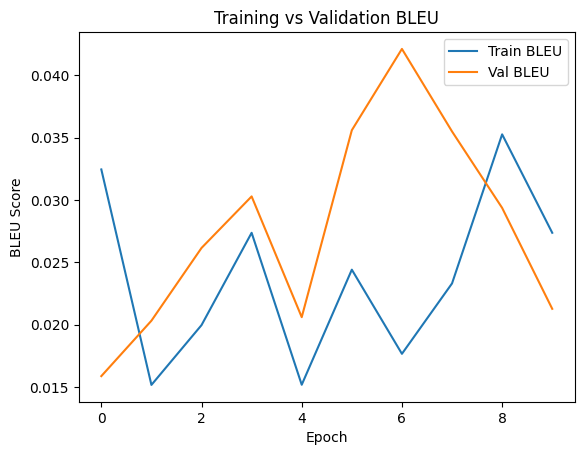

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Predicted Caption: <SOS> a dog is running through the grass .
Reference Caption: a dog jumps over a hurdle .


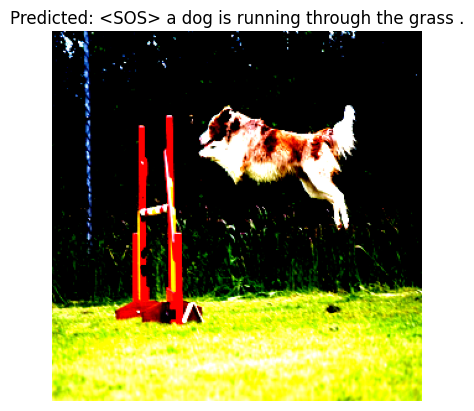

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Predicted Caption: <SOS> a man in a red shirt is standing on a rock with a <UNK> in his hand .
Reference Caption: a man in a white shirt is standing on a trail in the woods .


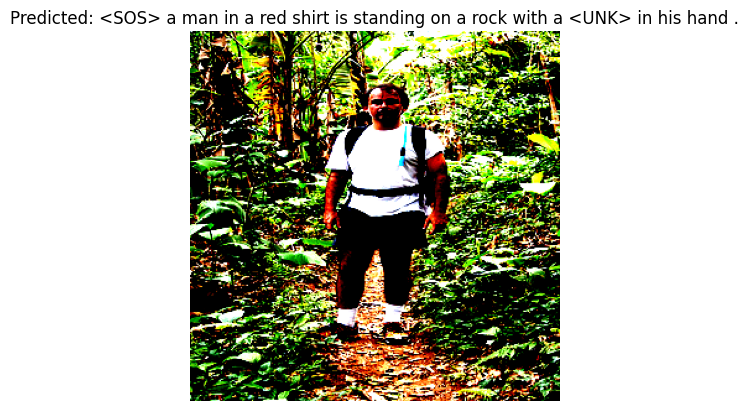

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Predicted Caption: <SOS> a man in a red shirt is standing on a rock with a <UNK> in his mouth .
Reference Caption: the children play in the pool .


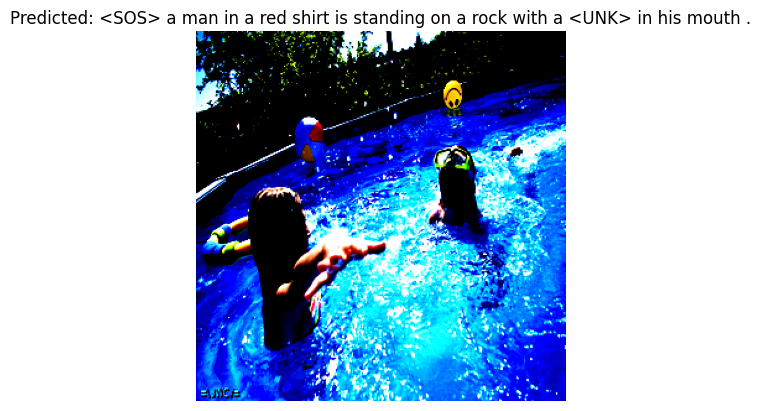

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


Predicted Caption: <SOS> a man in a red shirt is standing on a rock with a <UNK> in his hand .
Reference Caption: a group of people standing on a rock path .


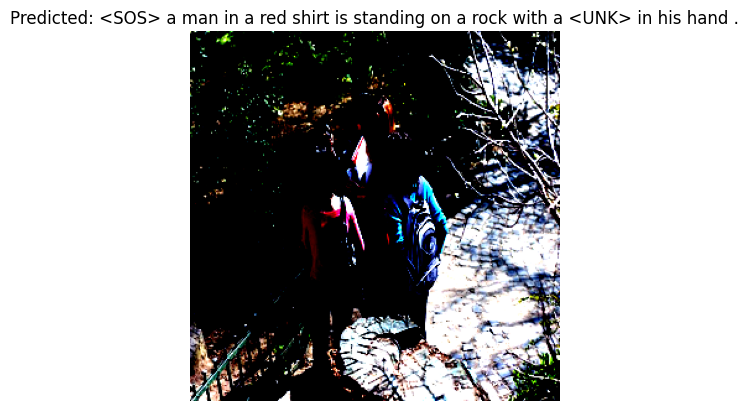

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6855742..2.3611329].


Predicted Caption: <SOS> a dog is running through the grass .
Reference Caption: two white dogs are running and jumping along a beach with the ocean behind them .


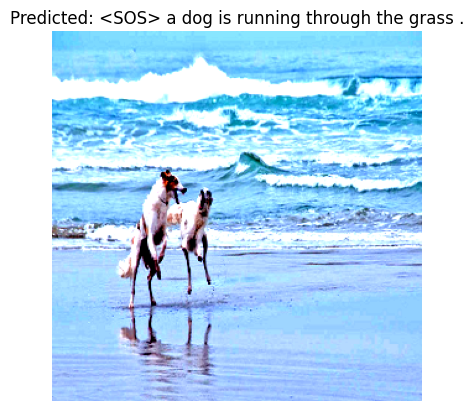

In [1]:
import os
import pandas as pd
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torchvision.models as models
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import random
from torchvision.models import Inception_V3_Weights

spacy_eng = spacy.load("en_core_web_sm")

###########################################################
# Vocabulary
###########################################################
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

###########################################################
# Dataset & Dataloader
###########################################################
class FlickrDataset(Dataset):
    def __init__(self, root_dir, df, transform=None, freq_threshold=5, vocab=None):
        self.root_dir = root_dir
        self.df = df
        self.transform = transform

        self.imgs = self.df["image"].values
        self.captions = self.df["caption"].values

        # If vocab not given, build it (for training)
        if vocab is None:
            self.vocab = Vocabulary(freq_threshold)
            self.vocab.build_vocabulary(self.captions.tolist())
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        # Compute lengths on CPU
        lengths = [len(t) for t in targets.permute(1,0)]
        lengths_cpu = torch.tensor(lengths, dtype=torch.int64)

        return imgs, targets, lengths_cpu

def get_loader(root_folder, df, vocab=None, transform=None, batch_size=32, num_workers=0, shuffle=True, pin_memory=False):
    dataset = FlickrDataset(root_folder, df, transform=transform, vocab=vocab)
    pad_idx = dataset.vocab.stoi["<PAD>"]
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    return loader, dataset

###########################################################
# Models
###########################################################
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.inception = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        output = self.inception(images)
        # Check if output is a tuple or not
        if isinstance(output, tuple):
            # Training mode: main_output and aux_output
            features, aux_features = output
        else:
            # Eval mode: only main output
            features = output

        features = self.dropout(self.relu(features))
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions[:-1]) # teacher forcing
        return outputs

    def caption_image(self, image, vocab, max_length=50):
        result_caption = []
        device = image.device
        with torch.no_grad():
            # Ensure image is batched
            if image.dim() == 3:
                image = image.unsqueeze(0)
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocab.itos[predicted.item()] == "<EOS>":
                    break

        return [vocab.itos[idx] for idx in result_caption]

###########################################################
# BLEU Evaluation
###########################################################
def evaluate_bleu_score(model, loader, vocab, device, sample_size=100):
    model.eval()
    references = []
    candidates = []
    chencherry = SmoothingFunction()

    sampled_indices = random.sample(range(len(loader.dataset)), min(sample_size, len(loader.dataset)))

    for idx in sampled_indices:
        img, caption = loader.dataset[idx]
        # Move to device and batchify
        img = img.unsqueeze(0).to(device)
        ref = caption.tolist()
        ref_tokens = [vocab.itos[tok] for tok in ref if tok not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]]
        references.append([ref_tokens])

        with torch.no_grad():
            pred = model.caption_image(img, vocab)
        pred_tokens = [w for w in pred if w not in ["<EOS>", "<PAD>"]]
        candidates.append(pred_tokens)

    bleu = corpus_bleu(references, candidates, smoothing_function=chencherry.method1)
    return bleu

###########################################################
# Training / Data Splits
###########################################################
full_df = pd.read_csv("captions.txt")
unique_images = full_df['image'].unique()
train_images, temp_images = train_test_split(unique_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

train_df = full_df[full_df['image'].isin(train_images)].reset_index(drop=True)
val_df = full_df[full_df['image'].isin(val_images)].reset_index(drop=True)
test_df = full_df[full_df['image'].isin(test_images)].reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

temp_dataset = FlickrDataset("Images/", train_df, transform=transform)
vocab = temp_dataset.vocab

train_loader, _ = get_loader("Images/", train_df, vocab=vocab, transform=transform, batch_size=32)
val_loader, _ = get_loader("Images/", val_df, vocab=vocab, transform=transform, batch_size=32, shuffle=False)
test_loader, _ = get_loader("Images/", test_df, vocab=vocab, transform=transform, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
hidden_size = 256
num_layers = 1
learning_rate = 3e-4
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])

model = CNNtoRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_val_bleu = 0.0
patience = 3
trigger_times = 0

train_bleus = []
val_bleus = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, captions, lengths_cpu in train_loader:
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions)
        seq_len, batch_size_, vocab_size_ = outputs.shape
        outputs = outputs.view(-1, vocab_size_)
        targets = captions.view(-1)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate BLEU on train and val sets
    train_bleu = evaluate_bleu_score(model, train_loader, vocab, device, sample_size=100)
    val_bleu = evaluate_bleu_score(model, val_loader, vocab, device, sample_size=100)
    train_bleus.append(train_bleu)
    val_bleus.append(val_bleu)
    print(f"Train BLEU: {train_bleu:.4f}, Val BLEU: {val_bleu:.4f}")

    # Check for early stopping
    if val_bleu > best_val_bleu:
        best_val_bleu = val_bleu
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model improved and saved.")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

# Load best model for final test evaluation
model.load_state_dict(torch.load('best_model.pth'))

test_bleu = evaluate_bleu_score(model, test_loader, vocab, device, sample_size=100)
print("Test BLEU Score:", test_bleu)

# Plot BLEU scores
plt.plot(range(len(train_bleus)), train_bleus, label='Train BLEU')
plt.plot(range(len(val_bleus)), val_bleus, label='Val BLEU')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('Training vs Validation BLEU')
plt.legend()
plt.show()

# Show sample images and captions from test set
model.eval()
indices = random.sample(range(len(test_loader.dataset)), 5)
for idx in indices:
    img, caption = test_loader.dataset[idx]
    img_show = img.permute(1,2,0).numpy()
    plt.imshow(img_show)
    plt.axis('off')

    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_caption = model.caption_image(img, vocab)

    pred_caption = [w for w in pred_caption if w not in ["<EOS>", "<PAD>"]]

    ref = caption.tolist()
    ref_tokens = [vocab.itos[tok] for tok in ref if tok not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]]

    print("Predicted Caption:", " ".join(pred_caption))
    print("Reference Caption:", " ".join(ref_tokens))
    plt.title("Predicted: " + " ".join(pred_caption))
    plt.show()